# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
### 構造推計（structural estimation）

In [42]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, golden, minimize_scalar
import scipy.stats as stats
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
from locate import locate

In [2]:
class Params:
    def __init__(self,β,γ,r,η,ss,surv,nz,tran,endow,max_age,ret_age,na,amax,amin,agrid):
        # パラメータ
        self.β = β             # 割引因子
        self.γ = γ             # 相対的危険回避度
        self.r = r             # 利子率

        self.η = η             # 年齢・所得プロファイル
        self.ss = ss           # 公的年金

        self.surv = surv       # 生存確率

        self.nz = nz           # 所得リスクのグリッドサイズ
        self.tran = tran       # 遷移確率行列
        self.endow = endow     # 所得リスクの実現値

        self.max_age = max_age # 最大年齢
        self.ret_age = ret_age # 引退年齢
        
        # グリッド
        self.na = na           # 貯蓄グリッド数
        self.amax = amax       # 貯蓄グリッドの最大値
        self.amin = amin       # 貯蓄グリッドの最小値
        self.agrid = agrid     # 貯蓄グリッド

In [3]:
# CSV形式でまとめたカリブレーションパラメータを読み込む
df = np.loadtxt("earnings_profiles.csv",delimiter=',',skiprows=1,encoding="utf-8_sig")
η = df[:, 1]

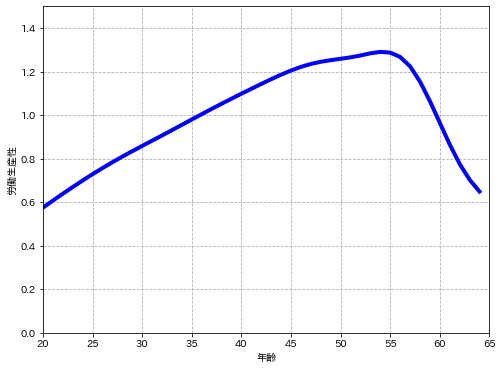

In [4]:
age = np.arange(20,64+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,η,c="b",lw=4)
ax.set(xlabel="年齢",ylabel="労働生産性",xlim=(20,65),ylim=(0,1.5))
ax.grid(ls="--")
plt.show()

In [5]:
# CSV形式でまとめたカリブレーションパラメータを読み込む
df = np.loadtxt("surv.csv",delimiter=',',skiprows=1,encoding="utf-8_sig")
surv = df[:, 1]

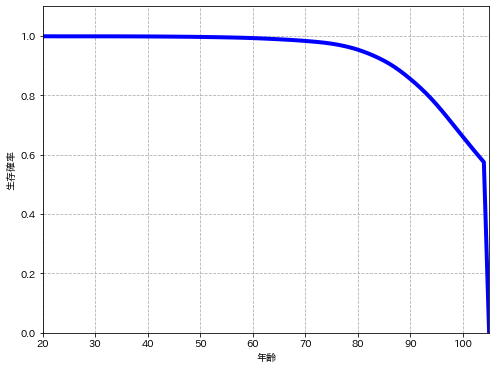

In [6]:
age = np.arange(20,105+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,surv,c="b",lw=4)
ax.set(xlabel="年齢",ylabel="生存確率",xlim=(20,105),ylim=(0,1.1))
ax.grid(ls="--")
plt.show()

In [7]:
def calibration():

    β = 0.98
    γ = 1.0
    r = 0.04

    # 労働所得プロファイル
    df = np.loadtxt("earnings_profiles.csv",delimiter=',',skiprows=1,encoding="utf-8_sig")
    η = df[:,1]
    ss = 0.5 # 所得代替率でカリブレート
    
    # 生存確率
    df = np.loadtxt("surv.csv",delimiter=',',skiprows=1,encoding="utf-8_sig")
    surv = df[:,1]
    
    nz = 3
    tran = np.array([[0.7451,0.2528,0.0021],[0.1360,0.7281,0.1360],[0.0021,0.2528,0.7451]])
    endow = np.array([0.8027, 1.0, 1.2457])

    max_age = 86 # 20歳から105歳まで
    ret_age = 45 # 20歳から64歳まで

    na = 101
    amax = 40.0
    amin = 0.0

    # numpyで等分グリッドを計算
    agrid = np.linspace(amin,amax,na)

    return Params(β,γ,r,η,ss,surv,nz,tran,endow,max_age,ret_age,na,amax,amin,agrid)

In [8]:
params = calibration()

---

## 経済学でよく使う関数

In [9]:
import MyEconFcn

---

## VFIのための準備
* 有限期間なので後ろ向きに解いていく

#### 現役期と引退期用の変数を設定
* 現役時代は資産$a$に加えて、労働生産性$z$と年齢$j$が状態変数になる
* 引退後は労働生産性が存在しなくなるので、$a$と$j$の2状態変数
* つまり、途中で変数のサイズが変わるので、それに対応した特別な変数を用意する
    * ⬇の書き方だと、x.yngは3状態変数、x.oldは2状態変数の変数
* 最大公約数的にずっと3状態変数で1期から86期までを定義しても計算上は全く問題ない
    * ただし、メモリの無駄使い
* x.oldの年齢のインデックスは0からスタートする点に注意

In [10]:
# 価値関数と政策関数用のclassを用意
class LifeCycleVariable:
    def __init__(self,yng,old):
        self.yng = yng
        self.old = old

In [11]:
# value function
vfcn = LifeCycleVariable(np.zeros((params.na,params.nz,params.ret_age)),np.zeros((params.na, params.max_age-params.ret_age)))

In [12]:
# policy function
pfcn = LifeCycleVariable(np.zeros((params.na,params.nz,params.ret_age)),np.zeros((params.na, params.max_age-params.ret_age)))

---

## 引退期の価値関数

#### 最終期の価値関数

In [13]:
ret_period = params.max_age - params.ret_age

# 最終期はすべての資源を使い切る(pythonはインデックスの始まりが0であることに注意)
for i in range(params.na):
    vfcn.old[i, ret_period-1] = MyEconFcn.crra((1+params.r)*params.agrid[i] + params.ss, params.γ)
    pfcn.old[i, ret_period-1] = 0.0

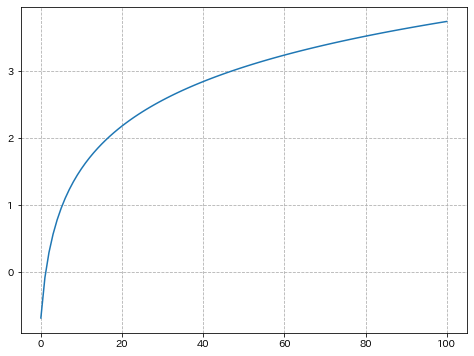

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(vfcn.old[:,ret_period-1])
ax.grid(ls="--")
plt.show()

In [15]:
vnext = interp1d(params.agrid,vfcn.old[:,ret_period-1],kind="cubic",fill_value="extrapolate")

In [16]:
def bellman_eq_retired(params,i,age,aprime,vnext):
    """
    ----------------------------
    === 引退期のベルマン方程式 ===
    ----------------------------
    <input>
    ・params: パラメータなどを含むオブジェクト
    ・i: 今期の貯蓄(値ではなくインデックスである点に注意)
    ・age: 現在の年齢
    ・aprime: 次期に残す貯蓄額
    ・vnext: スプライン補間した次期の価値関数
    <output>
    ・value: 負値にしたベルマン方程式
    """

    wealth = (1+params.r)*params.agrid[i] + params.ss
    cons = wealth - aprime
    util = MyEconFcn.crra(cons, params.γ)
    vnext = params.surv[age]*params.β*vnext(aprime)
    value = util + vnext
    value = -1*value

    return value


In [17]:
for age in reversed(range(params.ret_age,params.max_age-1)):

    # モデル上は20歳〜105歳だけど、引退直後(65歳)のindexは0なので注意
    age_ind = age - params.ret_age 
    
    # 次期の価値関数を補間
    vnext = interp1d(params.agrid,vfcn.old[:,age_ind+1],kind="cubic",fill_value="extrapolate")

    # 各資産の状態に応じて最適な貯蓄を探す
    for i in range(params.na):

        bellman_eq_retired1 = lambda aprime: bellman_eq_retired(params,i,age,aprime,vnext)
        wealth = (1+params.r)*params.agrid[i] + params.ss
        res = minimize_scalar(bellman_eq_retired1,bounds=(0.0,wealth-1e-10), method="bounded")
        pfcn.old[i, age_ind] = res.x
        vfcn.old[i, age_ind] = -res.fun

In [18]:
params.max_age

86

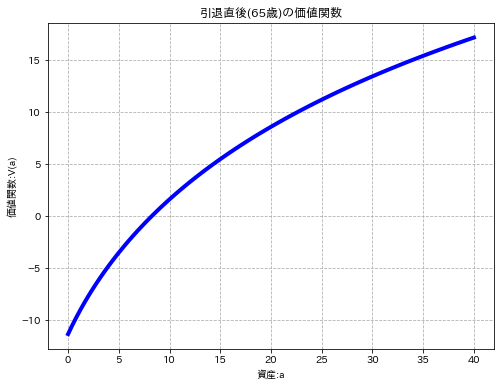

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.agrid,vfcn.old[:,0],c="b",lw=4)
ax.set(xlabel="資産:a",ylabel="価値関数:V(a)",title="引退直後(65歳)の価値関数")
ax.grid(ls="--")
plt.show()

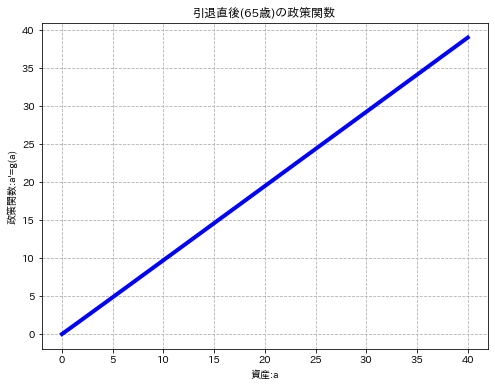

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.agrid,pfcn.old[:,0],c="b",lw=4)
ax.set(xlabel="資産:a",ylabel="政策関数:a'=g(a)",title="引退直後(65歳)の政策関数")
ax.grid(ls="--")
plt.show()

---

## 若年期の意思決定

In [21]:
def bellman_eq_worker(params,i,z,age,aprime,vnext_yng_sp,vnext_yng_li,vnext_old):
    """
    === 若年期のベルマン方程式 ===
    <input>
    ・params: パラメータ等を含む構造体
    ・i: 今期の貯蓄(値ではなくインデックス)
    ・z: 今期の労働賦存量(値ではなくインデックス)
    ・age: 年齢
    ・aprime: 次期に残す貯蓄額
    ・vnext_yng_sp: スプライン補間した次期の若年期の価値関数(nz*1)
    ・vnext_yng_li: 線形近似した次期の若年期の価値関数(nz*1)
    ・vnext_old: スプライン補間した次期の老年期の価値関数(nz*1)
    <output>
    ・value: 負値にしたベルマン方程式
    """

    # 現在の効用
    wealth = (1+params.r)*params.agrid[i] + params.η[age]*params.endow[z]
    cons = wealth - aprime
    util = MyEconFcn.crra(cons, params.γ)

    # 次期の期待効用
    if age == params.ret_age-1:
        # 引退直前であれば次期にはzの不確実性は存在しないので期待値計算は不要
        vnext = params.surv[age]*params.β*vnext_old(aprime)
    else:
        
        vnext_z = np.zeros(params.nz)
        # それぞれの次期のzに対応したvalueを計算
        for zz in range(params.nz):

            if aprime <= params.agrid[params.na-1]:

                spl_coef = vnext_yng_sp[zz]
                vnext_z[zz] = spl_coef(aprime)

            else:
                li_coef = vnext_yng_li[zz]
                vnext_z[zz] = li_coef(aprime)
            
            # 遷移確率行列で期待値を計算
            vnext = params.surv[age]*params.β*np.dot(params.tran[z, :], vnext_z)

    value = util + vnext
    value = -1*value

    return value 

In [22]:
vnext_old = interp1d(params.agrid,vfcn.old[:,0],kind="cubic",fill_value="extrapolate")

In [23]:
# 価値関数を繰り返し計算
for age in reversed(range(0,params.ret_age)):

    vnext_yng_sp = [] # 空のリストを用意して、そこに補完した関数をapppendしていく
    vnext_yng_li = []
    
    # 次期の価値関数を補間
    if age < params.ret_age-1:
        
        for z in range(params.nz):
            vnext_yng_sp.append(interp1d(params.agrid,vfcn.yng[:,z,age+1],kind="cubic",fill_value="extrapolate"))
            vnext_yng_li.append(interp1d(params.agrid,vfcn.yng[:,z,age+1],kind="linear",fill_value="extrapolate"))
        
    for i in range(params.na):
        for z in range(params.nz):

            bellman_eq_worker1 = lambda aprime: bellman_eq_worker(params, i, z, age, aprime, vnext_yng_sp, vnext_yng_li, vnext_old)
            wealth = (1+params.r)*params.agrid[i] + params.η[age]*params.endow[z]
            res = minimize_scalar(bellman_eq_worker1,bounds=(0.0,wealth-1e-10), method="bounded")
            pfcn.yng[i,z,age] = res.x
            vfcn.yng[i,z,age] = -res.fun

---

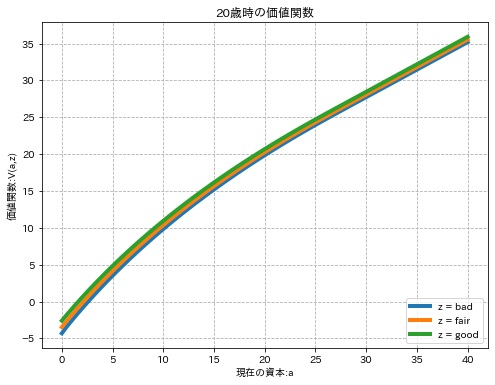

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.agrid,vfcn.yng[:,0,0],lw=4,label="z = bad")
ax.plot(params.agrid,vfcn.yng[:,1,0],lw=4,label="z = fair")
ax.plot(params.agrid,vfcn.yng[:,2,0],lw=4,label="z = good")
ax.set(xlabel="現在の資本:a",ylabel="価値関数:V(a,z)",title="20歳時の価値関数")
ax.legend(loc="lower right")
ax.grid(ls="--")
plt.show()

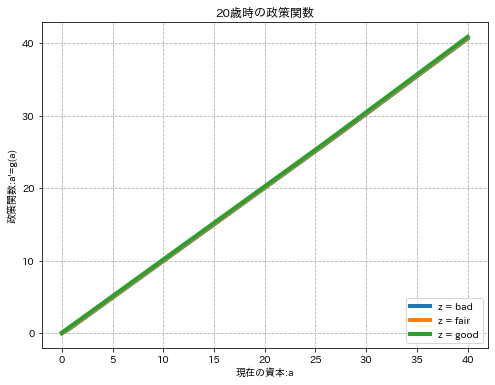

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.agrid,pfcn.yng[:,0,0],lw=4,label="z = bad")
ax.plot(params.agrid,pfcn.yng[:,1,0],lw=4,label="z = fair")
ax.plot(params.agrid,pfcn.yng[:,2,0],lw=4,label="z = good")
ax.set(xlabel="現在の資本:a",ylabel="政策関数:a'=g(a)",title="20歳時の政策関数")
ax.legend(loc="lower right")
ax.grid(ls="--")
plt.show()

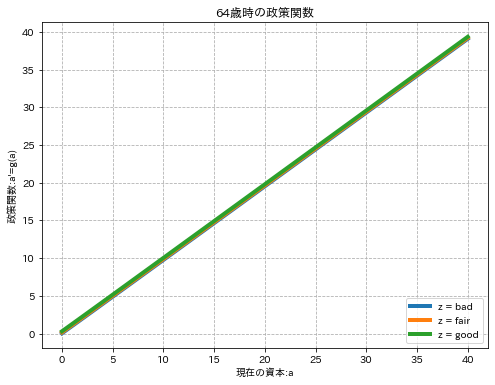

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.agrid,pfcn.yng[:,0,params.ret_age-1],lw=4,label="z = bad")
ax.plot(params.agrid,pfcn.yng[:,1,params.ret_age-1],lw=4,label="z = fair")
ax.plot(params.agrid,pfcn.yng[:,2,params.ret_age-1],lw=4,label="z = good")
ax.set(xlabel="現在の資本:a",ylabel="政策関数:a'=g(a)",title="64歳時の政策関数")
ax.legend(loc="lower right")
ax.grid(ls="--")
plt.show()

---

## シミュレーション
### num_sim人分の乱数を生成
* それぞれret_age期間の所得リスクをシミュレーション
* ここの書き方はもっと効率的にコーディング出来そう

In [106]:
# シミュレーションをする人数を設定
num_sim = 1000

In [107]:
# 一様分布を生成
uni_rand = stats.uniform.rvs(size=(params.ret_age,num_sim))

In [108]:
seq_endow = np.zeros((params.ret_age, num_sim),dtype=int)

#### zの初期分布は一様分布を仮定
* good, fair, badがそれぞれ1/3ずつ存在

In [109]:
z_ini_cdf = np.zeros(params.nz+1)
for i in range(params.nz):
    z_ini_cdf[i+1] = z_ini_cdf[i] + 1/params.nz

In [110]:
for j in range(num_sim):
   seq_endow[0, j] = locate(z_ini_cdf, uni_rand[0, j]) 

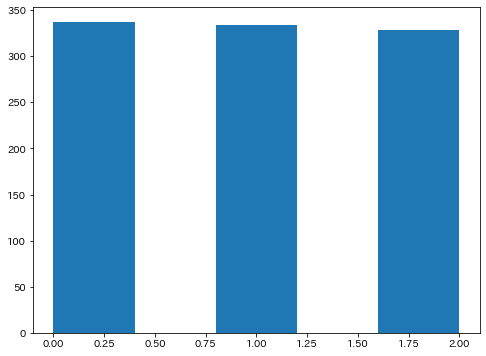

In [124]:
# good、fair、badが一様分布していることを確認
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(seq_endow[0,:],bins=5)
plt.show()

In [112]:
# 遷移確率行列からzの累積密度分布を計算
z_cdf = np.zeros((params.nz, params.nz+1))
for i in range(params.nz):
    for j in range(params.nz):
        z_cdf[i,j+1] = z_cdf[i, j] + params.tran[i, j]

In [113]:
# ret_age-1期間のシミュレーション
for j in range(num_sim):
    for i in range(1,params.ret_age):
        seq_endow[i, j] = locate(z_cdf[seq_endow[i-1, j], :], uni_rand[i, j])


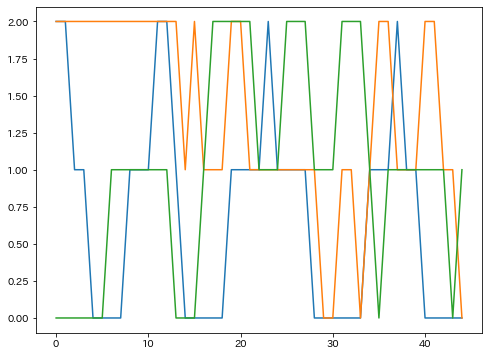

In [114]:
# 3人分の46期間の動きを確認
fig, ax = plt.subplots(figsize=(8,6)) 
ax.plot(seq_endow[:,0])
ax.plot(seq_endow[:,1])
ax.plot(seq_endow[:,2])
plt.show()

---

### 政策関数を使って前向きに解いていく

In [115]:
a_sim = np.zeros((params.max_age, num_sim))
y_sim = np.zeros((params.ret_age, num_sim))
c_sim = np.zeros((params.max_age, num_sim))

In [116]:
# 計算した政策関数を使ってシミュレーション
for j in range(num_sim):
    
    # 労働者
    for age in range(params.ret_age):

        y_sim[age, j] = η[age]*params.endow[seq_endow[age, j]]
        wealth = (1+params.r)*a_sim[age, j] + y_sim[age, j]
        
        # 資産が大きすぎて定義域の外まで増えた場合、スプラインではなく線形近似を使う
        # そもそもグリッドを調整すべき問題なので定義域の外に行かないようにモデルのパラメータを設定
        if a_sim[age, j] <= params.agrid[params.na-1]:
            interp_coef = interp1d(params.agrid,pfcn.yng[:, seq_endow[age, j], age],kind="cubic",fill_value="extrapolate")
        else:
            interp_coef = interp1d(params.agrid,pfcn.yng[:, seq_endow[age, j], age],kind="linear",fill_value="extrapolate")

        a_sim[age+1,j] = interp_coef(a_sim[age, j])
        c_sim[age, j] = wealth - a_sim[age+1, j]
    
    # 引退
    for age in range(params.ret_age,params.max_age):

        i = age - params.ret_age
        wealth = (1+params.r)*a_sim[age, j] + params.ss

        if a_sim[age, j] <= params.agrid[params.na-1]:
            interp_coef = interp1d(params.agrid,pfcn.old[:,i],kind="cubic",fill_value="extrapolate")
        else:
            interp_coef = interp1d(params.agrid,pfcn.old[:,i],kind="linear",fill_value="extrapolate")
        
        if age < params.max_age-1:

            a_sim[age+1, j] = interp_coef(a_sim[age, j])
            c_sim[age, j] = wealth - a_sim[age+1, j]

        elif age == params.max_age-1:
            
            c_sim[age, j] = wealth

### 平均プロファイルを計算

In [117]:
a_prof = np.zeros(params.max_age)
c_prof = np.zeros(params.max_age);

In [118]:
# 年齢ごとの平均値
for age in range(params.max_age):
    a_prof[age] = sum(a_sim[age, :]) / num_sim
    c_prof[age] = sum(c_sim[age, :]) / num_sim

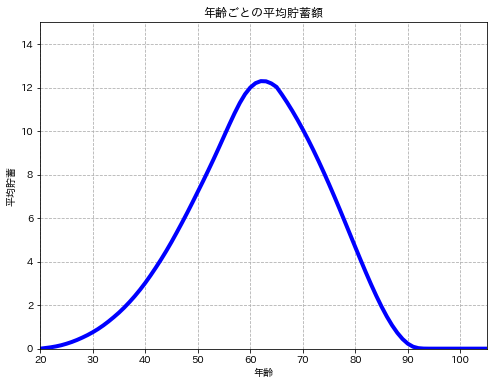

In [119]:
age = range(20,105+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,a_prof,c="b",lw=4)
ax.set(xlabel="年齢",ylabel="平均貯蓄",title="年齢ごとの平均貯蓄額",xlim=(20,105),ylim=(0,15.0))
ax.grid(ls="--")
plt.show()

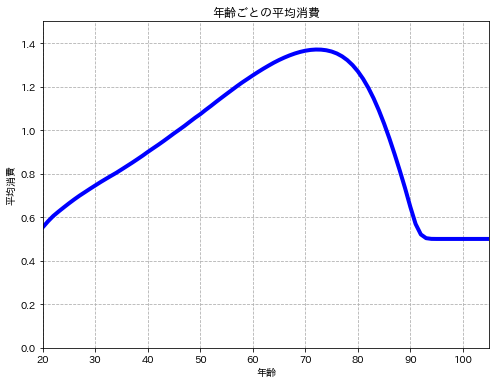

In [120]:
age = range(20,105+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,c_prof,c="b",lw=4)
ax.set(xlabel="年齢",ylabel="平均消費",title="年齢ごとの平均消費",xlim=(20,105),ylim=(0,1.5))
ax.grid(ls="--")
plt.show()

---

## シミュレーション結果をプロット

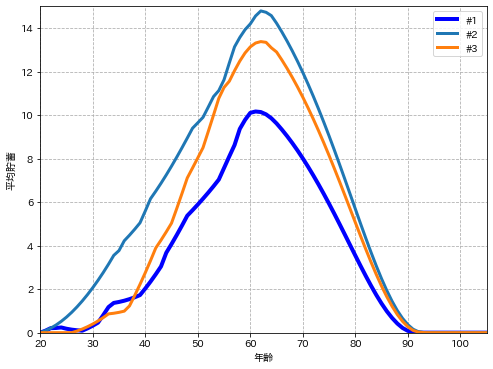

In [121]:
age = range(20,105+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,a_sim[:,0],c="b",lw=4,label="#1")
ax.plot(age,a_sim[:,1],lw=3,label="#2")
ax.plot(age,a_sim[:,2],lw=3,label="#3")
ax.set(xlabel="年齢",ylabel="平均貯蓄",xlim=(20,105),ylim=(0,15.0))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

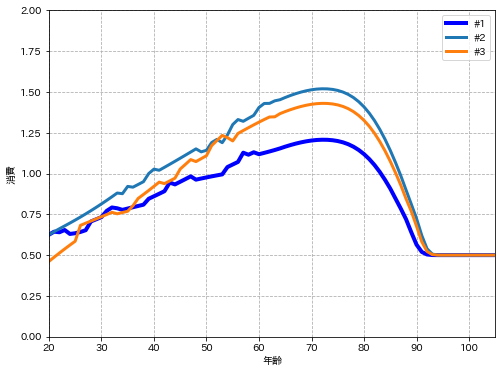

In [122]:
age = range(20,105+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(age,c_sim[:,0],c="b",lw=4,label="#1")
ax.plot(age,c_sim[:,1],lw=3,label="#2")
ax.plot(age,c_sim[:,2],lw=3,label="#3")
ax.set(xlabel="年齢",ylabel="消費",xlim=(20,105),ylim=(0,2.0))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* 価値関数の近似で定義域の外を線形補間で外挿しているが、これを3次のスプライン近似あるいは別の方法に切り替えた場合に何が起こるかを確認してみよう。